# <div align="center">Clustering State Level COVID Economic Metrics</div> #


**<div align="center">Barrett Nibling</div>**
**<div align="center">bnibling@gmail.com</div>**

**Updated: Weekly Economic Metric Data with Choropleth Map**

In [1]:
%reload_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import numpy as np
import pandas as pd
from functools import reduce
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from ipywidgets import interact

%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import umap
from sklearn.manifold import Isomap, LocallyLinearEmbedding, TSNE
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score


pd.set_option("display.max_columns", None)

<IPython.core.display.Javascript object>

In [3]:
spending_df = pd.read_csv("./data/Affinity - State - Daily.csv")
jobposting_df = pd.read_csv("./data/Burning Glass - State - Weekly.csv")
employment_df = pd.read_csv("./data/Employment Combined - State - Daily.csv")
uiclaims_df = pd.read_csv("./data/UI Claims - State - Weekly.csv")
sbopen_df = pd.read_csv("./data/Womply Merchants - State - Daily.csv")
sbrev_df = pd.read_csv("./data/Womply Revenue - State - Daily.csv")
geo_df = pd.read_csv("./data/GeoIDs - State.csv")
# us_census_st_df = pd.read_csv("./data/us census bureau regions and divisions.csv")

<IPython.core.display.Javascript object>

In [4]:
spending_df = spending_df.loc[(spending_df["month"] >= 4) & (spending_df["month"] <= 9)]
spending_df["spend_all"] = spending_df["spend_all"].astype(float)
spending_df = spending_df.rename(columns={"spend_all": "avg_spending"})
spending_df = spending_df[["year", "month", "day", "statefips", "avg_spending"]]
spending_df["date"] = pd.to_datetime(spending_df[["year", "month", "day"]])
spending_df["week"] = ((spending_df["date"] - pd.Timestamp("20200401")) / 7).dt.days
spending_df = spending_df.loc[(spending_df["week"] != 26)]
spending_df = spending_df.drop(["year", "day"], 1)
spending_df_grp = spending_df.groupby(["week", "statefips"]).mean()

<IPython.core.display.Javascript object>

In [5]:
jobposting_df = jobposting_df.loc[
    (jobposting_df["month"] >= 4) & (jobposting_df["month"] <= 9)
]
jobposting_df = jobposting_df.rename(
    columns={"bg_posts": "avg_jobpost", "day_endofweek": "day"}
)

jobposting_df = jobposting_df[["year", "month", "day", "statefips", "avg_jobpost"]]
jobposting_df.sort_values(by=["month", "day"], inplace=True)
jobposting_df["date"] = pd.to_datetime(jobposting_df[["year", "month", "day"]])
jobposting_df["week"] = ((jobposting_df["date"] - pd.Timestamp("20200401")) / 7).dt.days
jobposting_df = jobposting_df.drop(["year", "month", "day"], 1)
jobposting_df_grp = jobposting_df.groupby(["week", "statefips"]).mean()

<IPython.core.display.Javascript object>

In [6]:
employment_df = employment_df.loc[
    (employment_df["month"] >= 4) & (employment_df["month"] <= 9)
]
employment_df = employment_df.rename(columns={"emp_combined": "avg_emprate"})
employment_df = employment_df[["year", "month", "day", "statefips", "avg_emprate"]]
employment_df["date"] = pd.to_datetime(employment_df[["year", "month", "day"]])
employment_df["week"] = ((employment_df["date"] - pd.Timestamp("20200401")) / 7).dt.days
employment_df = employment_df.loc[(employment_df["week"] != 26)]
employment_df = employment_df.drop(["year", "month", "day"], 1)
employment_df_grp = employment_df.groupby(["week", "statefips"]).mean()

<IPython.core.display.Javascript object>

In [7]:
uiclaims_df = uiclaims_df.loc[(uiclaims_df["month"] >= 4) & (uiclaims_df["month"] <= 9)]
uiclaims_df = uiclaims_df.rename(
    columns={"initclaims_rate_combined": "avg_uiclaimrate", "day_endofweek": "day"}
)
uiclaims_df = uiclaims_df[["year", "month", "day", "statefips", "avg_uiclaimrate"]]
uiclaims_df["date"] = pd.to_datetime(uiclaims_df[["year", "month", "day"]])
uiclaims_df["week"] = ((uiclaims_df["date"] - pd.Timestamp("20200401")) / 7).dt.days
uiclaims_df = uiclaims_df.drop(["year", "month", "day"], 1)
uiclaims_df_grp = uiclaims_df.groupby(["week", "statefips"]).mean()

<IPython.core.display.Javascript object>

In [8]:
sbopen_df = sbopen_df.loc[(sbopen_df["month"] >= 4) & (sbopen_df["month"] <= 9)]
sbopen_df = sbopen_df.rename(columns={"merchants_all": "avg_sbopen"})
sbopen_df = sbopen_df[["year", "month", "day", "statefips", "avg_sbopen"]]
sbopen_df["date"] = pd.to_datetime(sbopen_df[["year", "month", "day"]])
sbopen_df["week"] = ((sbopen_df["date"] - pd.Timestamp("20200401")) / 7).dt.days
sbopen_df = sbopen_df.loc[(sbopen_df["week"] != 26)]
sbopen_df = sbopen_df.drop(["year", "month", "day"], 1)
sbopen_df_grp = sbopen_df.groupby(["week", "statefips"]).mean()

<IPython.core.display.Javascript object>

In [9]:
sbrev_df = sbrev_df.loc[(sbrev_df["month"] >= 4) & (sbrev_df["month"] <= 9)]
sbrev_df = sbrev_df.rename(columns={"revenue_all": "avg_sbrev"})
sbrev_df = sbrev_df[["year", "month", "day", "statefips", "avg_sbrev"]]
sbrev_df["date"] = pd.to_datetime(sbrev_df[["year", "month", "day"]])
sbrev_df["week"] = ((sbrev_df["date"] - pd.Timestamp("20200401")) / 7).dt.days
sbrev_df = sbrev_df.loc[(sbrev_df["week"] != 26)]
sbrev_df = sbrev_df.drop(["year", "month", "day"], 1)
sbrev_df_grp = sbrev_df.groupby(["week", "statefips"]).mean()

<IPython.core.display.Javascript object>

In [10]:
econ_grp_dfs = [
    spending_df_grp,
    jobposting_df_grp,
    employment_df_grp,
    uiclaims_df_grp,
    sbopen_df_grp,
    sbrev_df_grp,
]

econ_df_merged = reduce(
    lambda left, right: pd.merge(
        left,
        right,
        left_on=["week", "statefips"],
        how="inner",
        right_on=["week", "statefips"],
    ),
    econ_grp_dfs,
)
econ_df_merged.reset_index(inplace=True)

econ_df_merged = (
    econ_df_merged.reset_index().merge(geo_df, how="left").set_index("index")
)
econ_df_merged = econ_df_merged.drop(["statefips", "state_pop2019"], 1)

<IPython.core.display.Javascript object>

In [11]:
econ_df_merged

,week,month,avg_spending,avg_jobpost,avg_emprate,avg_uiclaimrate,avg_sbopen,avg_sbrev,statename,stateabbrev
index,,,,,,,,,,
0,0,4.0,-0.234714,-0.2180,-0.132286,4.760,-0.329000,-0.388143,Alabama,AL
1,0,4.0,-0.321429,-0.1350,-0.180714,4.200,-0.397714,-0.490429,Alaska,AK
2,0,4.0,-0.272000,-0.3370,-0.120286,3.730,-0.304429,-0.427143,Arizona,AZ
3,0,4.0,-0.197286,-0.3370,-0.120171,4.560,-0.263143,-0.349143,Arkansas,AR
4,0,4.0,-0.339571,-0.2300,-0.182857,4.730,-0.404571,-0.495429,California,CA
...,...,...,...,...,...,...,...,...,...,...
1321,25,9.0,-0.035043,-0.1570,-0.066443,0.283,-0.241429,-0.257429,Virginia,VA
1322,25,9.0,-0.057986,-0.1810,-0.040886,0.641,-0.267857,-0.277286,Washington,WA
1323,25,9.0,0.063243,-0.0812,-0.078757,0.239,-0.213857,-0.097443,West Virginia,WV


<IPython.core.display.Javascript object>

In [12]:
X = econ_df_merged.drop(["week", "month", "statename", "stateabbrev"], 1)

<IPython.core.display.Javascript object>

In [13]:
scaler = StandardScaler()
X_std = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

pca = PCA(n_components=2)
pca_df = pd.DataFrame(pca.fit_transform(X_std), columns=["c0", "c1"])

<IPython.core.display.Javascript object>

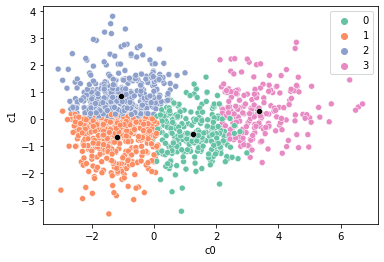

<IPython.core.display.Javascript object>

In [14]:
km4 = KMeans(n_clusters=4, random_state=42)
km4_preds = km4.fit_predict(X_std)
econ_df_merged["clusters"] = km4_preds
km4_cluster_centers = pd.DataFrame(
    scaler.inverse_transform(km4.cluster_centers_), columns=X_std.columns
).rename_axis("Clusters")
km4_cluster_centers["Count"] = pd.Series(km4_preds).value_counts()


pca_centers = pca.transform(km4.cluster_centers_)
sns.scatterplot(x=pca_df["c0"], y=pca_df["c1"], hue=km4_preds, palette="Set2")
sns.scatterplot(x=pca_centers[:, 0], y=pca_centers[:, 1], color="black")
plt.legend()
plt.show()

In [15]:
display(km4_cluster_centers.style.background_gradient())

,avg_spending,avg_jobpost,avg_emprate,avg_uiclaimrate,avg_sbopen,avg_sbrev,Count
Clusters,,,,,,,
0,-0.135013,-0.326422,-0.174340,2.073041,-0.316672,-0.326551,246
1,-0.067850,-0.221238,-0.086913,0.933052,-0.204964,-0.171601,445
2,-0.041413,-0.018175,-0.072903,0.900124,-0.267454,-0.267240,435
3,-0.271405,-0.301740,-0.217552,2.998565,-0.421855,-0.492776,200


<IPython.core.display.Javascript object>

The following is how the clusters will be re-ranked and defined:

Cluster 2 -> 4 - Economy is stabilizing except Small Businesses

Cluster 1 -> 3 - Economy is stabilizing except Job Postings

Cluster 0 -> 2 - Economy is instable (All metrics moderately low)

Cluster 3 -> 1 - Severe economic instability (All metrics are low)

In [16]:
econ_df_merged["new_clusters"] = econ_df_merged["clusters"].replace(
    {0: 2, 1: 3, 2: 4, 3: 1}
)

<IPython.core.display.Javascript object>

In [17]:
@interact()
def pca_scatter():
    pca = PCA(n_components=2, random_state=42)
    pca_data = pd.DataFrame(pca.fit_transform(X_std))
    pca_data["new_clusters"] = econ_df_merged["new_clusters"].astype("str")

    fig = px.scatter(
        pca_data,
        x=0,
        y=1,
        color="new_clusters",
        title=f"PCA of KMeans with 4 clusters",
    )
    fig.update_traces(marker_line_color="black", marker_line_width=1)
    fig.show()

interactive(children=(Output(),), _dom_classes=('widget-interact',))

<IPython.core.display.Javascript object>

In [18]:
@interact(n_neighbors=range(2, 25, 2), min_dist=np.arange(0, 1.0, 0.05))
def umap_scatter(n_neighbors, min_dist):
    umap_model = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, random_state=42)
    data_umap = pd.DataFrame(umap_model.fit_transform(X_std))
    data_umap["new_clusters"] = econ_df_merged["new_clusters"].astype("str")

    fig = px.scatter(
        data_umap,
        x=0,
        y=1,
        color="new_clusters",
        title=f"UMAP {n_neighbors} n_neighbors and {min_dist} min_dist",
    )
    fig.update_traces(marker_line_color="black", marker_line_width=1)
    fig.show()

interactive(children=(Dropdown(description='n_neighbors', options=(2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24)…

<IPython.core.display.Javascript object>

In [19]:
fig = px.choropleth(
    econ_df_merged,
    locations="stateabbrev",
    color="new_clusters",
    animation_frame="week",
    color_continuous_scale="spectral",
    locationmode="USA-states",
    scope="usa",
    range_color=(1, 4),
    title="Economic Status After COVID by Week per State",
    height=600,
)

fig.update_layout(
    coloraxis_colorbar=dict(
        title="Cluster Number",
        tickvals=[1, 2, 3, 4],
        ticktext=[
            "1- Severely unstable",
            "2- Moderately unstable",
            "3- Stabilizing/low small business growth",
            "4- Stabilizing/low job posting",
        ],
        lenmode="pixels",
        len=200,
    )
)

fig.show()

<IPython.core.display.Javascript object>